In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [ ]:
#pip install -U transformers tensorflow

In [ ]:
#pip install bertopic

In [ ]:
#pip install spacy

In [ ]:
#pip uninstall -y tensorflow && pip install tensorflow-cpu

In [ ]:
import torch
import torch.nn as nn
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm_notebook, trange
import os
from transformers import BertConfig, BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers.optimization import AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd
#from bertopic import BERTopic
import spacy
#from sentence_transformers import SentenceTransformer

In [ ]:
import os

directory = os.getcwd()
print(directory)

/content


In [ ]:
cols= ['target', 'id', 'date', 'flag', 'user', 'text']
data = pd.read_csv('./drive/MyDrive/training.tweets.processed.csv', encoding='ISO-8859-1', header= None, names= cols)

In [ ]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print(data[data['text'].isnull() == True])

Empty DataFrame
Columns: [target, id, date, flag, user, text]
Index: []


In [ ]:
data.shape

(1600000, 6)

In [ ]:
data['text'][1599996]

'TheWDB.com - Very cool to hear old Walt interviews!  â\x99« http://blip.fm/~8bmta'

In [ ]:
data['target'].unique()

array([0, 4])

In [ ]:
cols_to_drop = ['id', 'date', 'flag', 'user']
data2= data.drop(columns= cols_to_drop, axis = 1)

In [ ]:
data2['text'] = data2['text'].astype(str)

In [ ]:
data2['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## label encoding for the target value

In [ ]:
data2['target'] = [0 if label == 0 else 1 for label in data['target']]

In [ ]:
data2['target'].unique()

array([0, 1])

In [ ]:
len(data2)

1600000

In [ ]:
data2['text'] = data2['text'].dropna()

In [ ]:
len(data2)

1600000

In [ ]:
#downsample
sampled_tweets = data2['text'].sample(n= 8000, random_state= 42)

In [ ]:
len(sampled_tweets)

8000

Remove Stop Words

In [ ]:
nlp = spacy.load('en_core_web_sm')
filtered_tweets = []
for tweet in sampled_tweets:
  doc = nlp(tweet)
  filtered_texts = " ".join([token.text for token in doc if not token.is_stop])
  filtered_tweets.append(filtered_texts)
print(filtered_tweets[:4])

['@chrishasboobs AHHH HOPE OK ! ! !', '@misstoriblack cool , tweet apps   razr 2', '@TiannaChaos know   family drama . lame.hey time u hang kim n u guys like sleepover , ill u', "School email wo open   geography stuff revise ! * Stupid School * :'("]


In [ ]:
len(filtered_tweets)

8000

Topic Modeling

In [ ]:
Topic_Model = BERTopic()
topics, probs = Topic_Model.fit_transform(filtered_tweets)

Review Topics

In [ ]:
topic_info = Topic_Model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2932,-1_going_time_great_got,"[going, time, great, got, good, love, lol, day...","[Time start day, woke early today ... m kinda ..."
1,0,956,0_thanks_sorry_thank_lol,"[thanks, sorry, thank, lol, know, ok, good, ha...","[@mnemopsyche thank following . thanks , ., ..."
2,1,360,1_food_eating_eat_chocolate,"[food, eating, eat, chocolate, hungry, cream, ...","[eating banana ill ..., need food god feel s..."
3,2,244,2_rain_weather_raining_sun,"[rain, weather, raining, sun, snow, cold, stor...","[liking rain cold - heat sunshine gone ? !, @b..."
4,3,234,3_twitter_tweet_tweets_tweeting,"[twitter, tweet, tweets, tweeting, tweetdeck, ...","[Good morning twitter people !, new twitter, t..."
...,...,...,...,...,...
84,83,11,83_bbq_visit_weekend_mother,"[bbq, visit, weekend, mother, 140pm, digi, bbq...","[soo sunny ! want work , bbq tomorrow, Mother ..."
85,84,11,84_life_things_figuring_cons,"[life, things, figuring, cons, landon, unlikly...","[Figuring live life boss ... fun, Wait , scrat..."
86,85,11,85_30_os_itunes_iphone,"[30, os, itunes, iphone, apple, update, 106, t...",[OS 3 update? ....... . ( shakes head mopes...
87,86,11,86_nails_nail_thumb_gano,"[nails, nail, thumb, gano, httptwitpiccom7ohbq...","[thumb hurts breaking nail ...., @tieraa Awu t..."


In [ ]:
topic_keywords = Topic_Model.get_topics()
topic_keywords

{-1: [('going', 0.007385104141449898),
  ('time', 0.0072461969111582035),
  ('great', 0.007197973568882298),
  ('got', 0.006928171389698362),
  ('good', 0.006708693064190023),
  ('love', 0.0066659776262792386),
  ('lol', 0.006521201484966615),
  ('day', 0.006402995475747108),
  ('like', 0.0062827650888076765),
  ('today', 0.0062436300943591715)],
 0: [('thanks', 0.028206742720029293),
  ('sorry', 0.017650306484413875),
  ('thank', 0.0139301154742491),
  ('lol', 0.011809708447858626),
  ('know', 0.011284729130746794),
  ('ok', 0.010714897439086194),
  ('good', 0.009576960760573669),
  ('haha', 0.009118995793349238),
  ('following', 0.008801123875687192),
  ('oh', 0.008604797630538005)],
 1: [('food', 0.0313650717752791),
  ('eating', 0.027654592110614485),
  ('eat', 0.025876094541466724),
  ('chocolate', 0.024731910879806734),
  ('hungry', 0.020957296506681388),
  ('cream', 0.018037200497246733),
  ('coffee', 0.01762994190325326),
  ('tea', 0.016649723535920063),
  ('milk', 0.0165086179

In [ ]:
Topic_Model.visualize_heatmap()

In [ ]:
Topic_Model.visualize_hierarchy()

In [ ]:
Topic_Model.visualize_barchart()

K Means Clustering

In [ ]:
#BERT embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(filtered_tweets, show_progress_bar= False)
num_clusters = 10
kmeans = KMeans(n_clusters= num_clusters, random_state= 42)
kmeans.fit(embeddings)

KMeans(n_clusters=10, random_state=42)

In [ ]:
for i in range(num_clusters):
  cluster_indices = [index for index, label in enumerate(kmeans.labels_) if label == i]
  cluster_tweets = [filtered_tweets[idx] for idx in cluster_indices]
  print(f"Cluster {i+1}:")
  for tweet in cluster_tweets[:5]:
    print(tweet)
  print()

Cluster 1:
School email wo open   geography stuff revise ! * Stupid School * :'(
@wizely lol , calm .   got 30day loan offer 1500 %
@GogDog willing pay $ 40 - 50 ( covering cost set ) , got counter offer listen .
car poorly
msn making click wrong people . garrrrr

Cluster 2:
@TiannaChaos know   family drama . lame.hey time u hang kim n u guys like sleepover , ill u
@mrstessyman thank glad like ! product review bit site   Enjoy knitting !
@PerezHilton Zach makes pee sitting ! grown gay man !
@frandrescher Apparently nt time ur fans ! ! ! ! ! ! ! ! ! !
@edadkins ha ha want pictures minister ! ! !   * boobie flahses * ! ! ! !

Cluster 3:
lunch .... dj come eat
fizz cider
eating cha eric
Whipsnade   Hope dry
@Lujee seriosuly , second & quot;since mid . class dude work food&quot ;

Cluster 4:
sum day word ......... kackered !
day pass slowly .   days .   RAWR ! ! ! !   ...
woooooork tomorrrow&amp;tuesday
SuperCheap - successful trip . bikes tanked & amp ; checked week , ready start relaxing

Emotion Labeling

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('joeddav/distilbert-base-uncased-go-emotions-student')
model = AutoModelForSequenceClassification.from_pretrained('joeddav/distilbert-base-uncased-go-emotions-student')

tokenizer_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# List of emotions GoEmotions model is trained on
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]


## check for imbalanced dataset
### by looking at the sentiment distribution chart below, both target values are equally distributed. We do not have an imbalanced dataset.

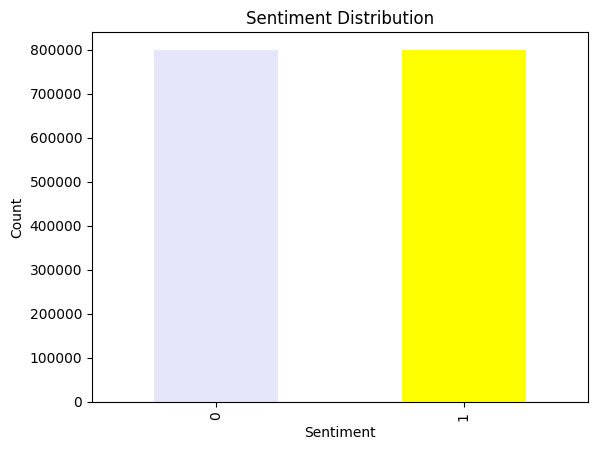

In [ ]:
import matplotlib.pyplot as plt
label_counts= pd.Series(data2['target']).value_counts()
label_counts.plot(kind= 'bar', color = ['lavender', 'yellow'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Embedding.
###### vectorizing the tokens into the continuous vector space. This vector representation captures semantic relationships. Embedding layer is used for NLP and important for transfer learning like BERT so the model understand contextual relationships between words.

In [ ]:
class BertForSequenceClassfication(nn.Module):
  "Bert model with a linear layer on top of the pooled out"
  def __init__(self, num_labels = 1):
    super(BertForSequenceClassfication, self).__init__()
    self.num_labels = num_labels
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, num_labels)
    nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids = None, attention_mask = None, labels = None):
    outputs = self.bert(input_ids, token_type_ids, attention_mask)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

  def freeze_bert_encoder(self):
    for param in self.bert.parameters():
      param.requires.grad = False

  def unfreeze_bert_encoder(self):
    for param in self.bert.parameters():
      param.requires_grad = True


In [ ]:
config = BertConfig(vocab_size_or_config_json_file = 70000, hidden_size = 768,
                    num_hidden_layers=12, num_attention_heads= 12, intermediate_size = 3072)

In [ ]:
num_labels = 1
model = BertForSequenceClassfication(num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text = list(data2['text'].items())
#a = data2['text'].apply(lambda x: tokenizer.tokenize(x) for x in text)

In [ ]:
text[:10]

[(0,
  "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 (1,
  "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 (2,
  '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 (3, 'my whole body feels itchy and like its on fire '),
 (4,
  "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "),
 (5, '@Kwesidei not the whole crew '),
 (6, 'Need a hug '),
 (7,
  "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?"),
 (8, "@Tatiana_K nope they didn't have it "),
 (9, '@twittera que me muera ? ')]

In [ ]:
text = data2['text'][3]
a = tokenizer.tokenize(text)

In [ ]:
a

['my',
 'whole',
 'body',
 'feels',
 'it',
 '##chy',
 'and',
 'like',
 'its',
 'on',
 'fire']

In [ ]:
ids = tokenizer.convert_tokens_to_ids(a)
ids

[2026, 2878, 2303, 5683, 2009, 11714, 1998, 2066, 2049, 2006, 2543]

In [ ]:
tokens_tensor = torch.tensor([ids])
tokens_tensor

tensor([[ 2026,  2878,  2303,  5683,  2009, 11714,  1998,  2066,  2049,  2006,
          2543]])

In [ ]:
logits = model(tokens_tensor)

In [ ]:
logits

tensor([[-1.2720]], grad_fn=<AddmmBackward0>)

In [ ]:
# test for the whole text
#b = data2['text'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
#b[:3]

## data processing

In [ ]:
def text2ids(text, max_seq_length = 300):
  tok_text = tokenizer.tokenize(text)
  if len(tok_text) > max_seq_length:
    tok_text = tok_text[: max_seq_length]
  ids_text = tokenizer.convert_tokens_to_ids(tok_text)
  padding = [0] * (max_seq_length - len(ids_text))
  ids_text += padding
  return np.array(ids_text)

In [ ]:
text2ids(data2['text'][2])

array([ 1030,  6358,  7033,  2319,  1045, 11529,  2094,  2116,  2335,
        2005,  1996,  3608,  1012,  3266,  2000,  3828,  2753,  1003,
        1996,  2717,  2175,  2041,  1997, 19202,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
class TwitterDatasetforBERT(Dataset):
  def __init__(self, data):
    self.data = data2
    self.y = self.data['target']
    self.files = list(self.data['text'].items())

  def __getitem__(self, index):
    x = text2ids(self.files[index][1])
    return x, self.y.iloc[index]

  def __len__(self):
    return len(self.y)

In [ ]:
train_data, valid_data = train_test_split(data2, test_size = 0.2, random_state = 42 )

In [ ]:
train_ds = TwitterDatasetforBERT(train_data)
valid_ds = TwitterDatasetforBERT(valid_data)

In [ ]:
batch_size = 10
train_dl= DataLoader(train_ds, batch_size=  batch_size, shuffle = True)
valid_dl= DataLoader(valid_ds, batch_size = batch_size )

In [ ]:
x , y = train_ds[0]

In [ ]:
x, y = next(iter(train_dl))

In [ ]:
x[4]

tensor([ 1030,  1047,  3207,  1035,  4116,  1030, 13012, 14907, 11387,  2475,
        17595,  2283,  9530, 12191,  2015,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
x.shape[0]

10

In [ ]:
def train_model(model, optimizer, num_epochs = 25):
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_dl:
      x = x.cuda()
      y = y.float().unsqueeze(1).cuda()
      optimizer.zero_grad()
      logits = model(x)
      loss = F.binary_cross_entropy_with_logits(logits, y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_ds)
    val_loss, accuracy = eval_model(model)
    print('train loss: {:.3f}, valid loss: {:.3f}, accuracy: {:.3f}'.format(
        epoch_loss, val_loss, accuracy
    ))

In [ ]:
def eval_model(model):
  model.eval()
  running_loss = 0.0
  correct = 0
  for x, y in valid_dl:
    x = x.long().cuda()
    y = y.float().unsqueeze(1).cuda()
    logits = model(x)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    y_pred = logits >0
    correct += (y_pred.float() == y).float().sum()
    running_loss += loss.item() * x.size(0)
  accuracy = correct / len(valid_ds)
  epoch_loss = running_loss / len(valid_ds)
  return epoch_loss, accuracy.item()


In [ ]:
model = model.cuda()

## differential learning rates
##### A higher learning rate is used for fine tuning the smaller task such as a classifier. A lower learning rate, on the other hand, is used to train the pretrained model. This approach of using different learning rates for different parts of the model is known as differential learning rates.

In [ ]:
lrlast = .0001
lrmain = .00001
optimizer = optim.Adam(
    [
        {"params": model.bert.parameters(), "lr": lrmain},
        {"params": model.classifier.parameters(), "lr": lrlast}
    ]
)